In [26]:
!git clone http://github.com/Zapy67/ATML-PA-4 test

Cloning into 'test'...
remote: Enumerating objects: 486, done.
remote: Counting objects: 100% (73/73), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 486 (delta 44), reused 67 (delta 42), pack-reused 413 (from 1)
Receiving objects: 100% (486/486), 4.16 MiB | 7.44 MiB/s, done.
Resolving deltas: 100% (344/344), done.


In [21]:
!git pull http://github.com/Zapy67/ATML-PA-4 test

remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (1/1), done.
remote: Total 5 (delta 4), reused 5 (delta 4), pack-reused 0 (from 0)
Unpacking objects: 100% (5/5), 2.74 KiB | 187.00 KiB/s, done.
From http://github.com/Zapy67/ATML-PA-4
 * branch            test       -> FETCH_HEAD
hint: You have divergent branches and need to specify how to reconcile them.
hint: You can do so by running one of the following commands sometime before
hint: your next pull:
hint: 
hint:   git config pull.rebase false  # merge (the default strategy)
hint:   git config pull.rebase true   # rebase
hint:   git config pull.ff only       # fast-forward only
hint: 
hint: You can replace "git config" with "git config --global" to set a default
hint: preference for all repositories. You can also pass --rebase, --no-rebase,
hint: or --ff-only on the command line to override the configured default per
hint: invocation.
fatal: Need to specify how to reco

In [32]:
cd test

/kaggle/working/test


In [33]:
ls

'ATML - PA 4.pdf'   fedprox.ipynb       LICENSE       task2.ipynb
 fedgh.ipynb        fedsam.ipynb        README.md     task3.ipynb
 fed_lib/           fedscaffold.ipynb   task1.ipynb   task4.ipynb


#  FedGH & Local Optimization

In [50]:
import torch
import torch.nn as nn

In [51]:
# !pip install fedlab

In [52]:
import fed_lib
import importlib
importlib.reload(fed_lib)

<module 'fed_lib' from '/kaggle/working/test/fed_lib/__init__.py'>

In [53]:
from fed_lib import fed_methods, fed_model, utils
importlib.reload(fed_methods)
importlib.reload(fed_model)
importlib.reload(utils)

<module 'fed_lib.utils' from '/kaggle/working/test/fed_lib/utils.py'>

In [54]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [38]:
trainset, testset = utils.get_cifar10()

100%|██████████| 170M/170M [00:06<00:00, 27.3MB/s] 


In [39]:
import matplotlib.pyplot as plt
def plot_fed_vs_central_acc(metrics, title="FedAvg vs Central Test Accuracy"):
    """
    Args:
        metrics (dict): self.round_metrics dictionary from FedSGD.
    """
    fed_acc = metrics.get('fed_test_acc', [])
    central_acc = metrics.get('central_test_acc', [])

    rounds = list(range(1, len(fed_acc) + 1))

    plt.figure(figsize=(8, 5))
    plt.plot(rounds, fed_acc, marker='o', label='FedAvg (Server) Accuracy')
    plt.plot(rounds, central_acc, marker='s', label='Central Model Accuracy')

    plt.xlabel("Round")
    plt.ylabel("Accuracy")
    plt.title(title)
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [40]:
def fed_gh_exp(lr=1e-3, num_steps=5, num_clients=5, partition="dirichlet", alpha=10000,device=device, global_runs=20, verbose=False, sampling_frac=1.0, rho=1e-3):
        fed = fed_model.Federation(num_clients=num_clients, federate_method=None, partition=partition, domains=None, alpha=alpha, device=device, batch_size=64, pin_memory=True, num_workers=2)
        client_loaders = fed.client_dataloaders
        client_weights = [len(client.dataset.indices)/len(trainset.dataset) for client in client_loaders]
        
        fed_meth = fed_methods.FedGH(local_epochs=1, aggregation_steps=num_steps, client_weights=client_weights, sample_fraction=sampling_frac)
        fed.set_method(fed_meth)
        fed.train(global_runs, lr=lr, verbose=verbose, train_central=False)

        return fed

In [41]:
import matplotlib.pyplot as plt

def plot_metrics(metrics:dict, title:str, label: str, label_desc:str):
    metric_map = {
        'fed_test_acc': 'Test Accuracy',
        'fed_test_loss': 'Test Loss',
        'client_drift': 'Client Drift (Norm)'
    }
    metric_order = ['fed_test_acc', 'fed_test_loss', 'client_drift']
    k_values = sorted(metrics.keys())

    fig, axes = plt.subplots(3, 1, figsize=(10, 10), sharex=True)
    fig.suptitle(title, fontsize=14)

    for i, metric_key in enumerate(metric_order):
        ax = axes[i]
        for k in k_values:
            values = metrics[k][metric_key]
            rounds = list(range(1, len(values) + 1))
            ax.plot(rounds, values, label=f'{label}={k}')
            
        ax.set_ylabel(metric_map[metric_key])
        ax.grid(axis='y', linestyle='--', alpha=0.6)    
        ax.legend(title=f'{label_desc} ({label})', loc='upper left')
            
    axes[-1].set_xlabel('Global Round')
    plt.show()

In [ ]:
#experimental setup 1.
from IPython.display import clear_output

metrics_exp_1 = {}
total_samples = len(trainset.dataset)
for alpha in [10000]: 
    f = fed_gh_exp(lr=1e-2, num_clients=1,num_steps=1, global_runs=30, sampling_frac=1.0, alpha=alpha)
    metrics_exp_1[alpha] = f.federated_method.round_metrics
    clear_output(wait=True)


--- Round 1/30 ---
Training Clients
Training Client 1/1 for 1 steps
Training Server

Client Drift Stats:
Client Drift Mean: 2.841645e-02
Client Drift Std: 0.000000e+00
Top 1 Clients with Greatest Drift
Client Number: 0 Drift :2.841645e-02

Evaluate on round 1:


FedGH  | Test Loss: 2.3033, Test Acc: 10.00%

--- Round 2/30 ---
Training Clients
Training Client 1/1 for 1 steps


Training Server

Client Drift Stats:
Client Drift Mean: 1.911486e-02
Client Drift Std: 0.000000e+00
Top 1 Clients with Greatest Drift
Client Number: 0 Drift :1.911486e-02

Evaluate on round 2:


FedGH  | Test Loss: 2.3032, Test Acc: 10.00%

--- Round 3/30 ---
Training Clients
Training Client 1/1 for 1 steps


Training Server

Client Drift Stats:
Client Drift Mean: 1.743899e-02
Client Drift Std: 0.000000e+00
Top 1 Clients with Greatest Drift
Client Number: 0 Drift :1.743899e-02

Evaluate on round 3:


FedGH  | Test Loss: 2.3032, Test Acc: 10.00%

--- Round 4/30 ---
Training Clients
Training Client 1/1 for 1 steps
Training Server

Client Drift Stats:
Client Drift Mean: 1.671980e-02
Client Drift Std: 0.000000e+00
Top 1 Clients with Greatest Drift
Client Number: 0 Drift :1.671980e-02

Evaluate on round 4:


FedGH  | Test Loss: 2.3031, Test Acc: 10.00%

--- Round 5/30 ---
Training Clients
Training Client 1/1 for 1 steps


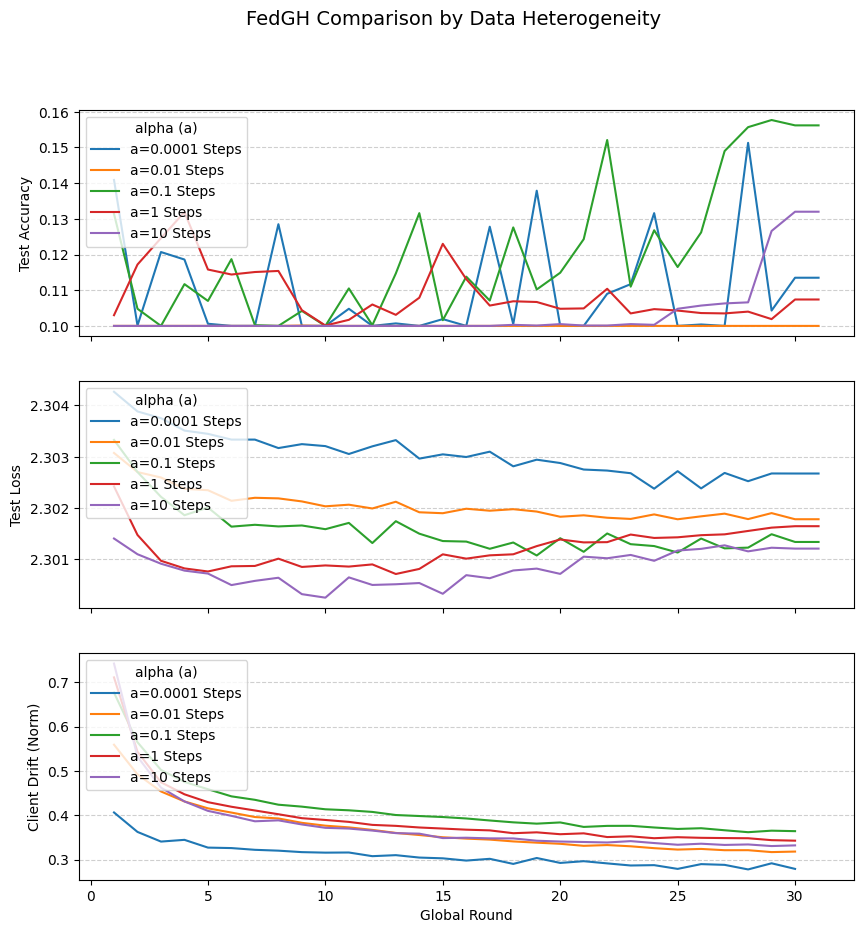

In [ ]:
plot_metrics(metrics_exp_1, "FedGH Comparison by Data Heterogeneity", label="a", label_desc="alpha")